In [2]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import KMeans
import h5py

DIR_DATASET = "./data_set/"

In [3]:
filename = "N-CMAPSS_DS06.h5"

In [4]:
# Load data
with h5py.File(DIR_DATASET + filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))

W shape: (6779656, 4)
X_s shape: (6779656, 14)
X_v shape: (6779656, 14)
T shape: (6779656, 10)
A shape: (6779656, 4)


In [5]:
df_A = DataFrame(data=A, columns=A_var)
df_W = DataFrame(data=W, columns=W_var)
df_W['unit'] = df_A['unit'].values


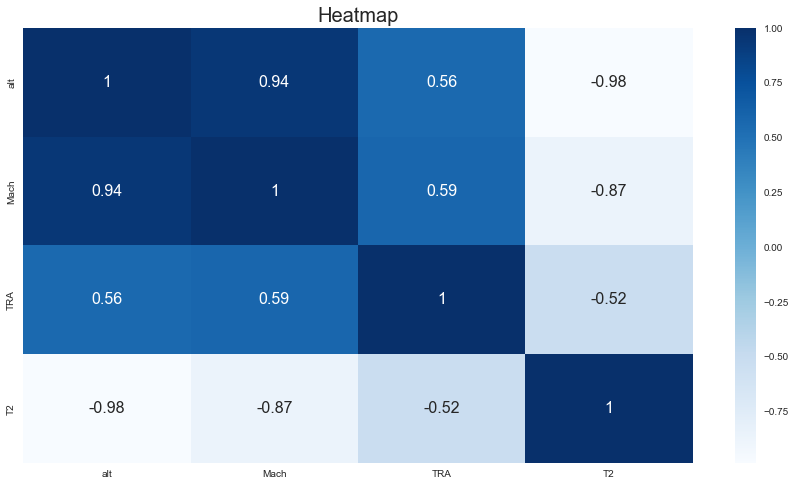

In [6]:
plt.figure(figsize=(15,8))
sns.heatmap(df_W.drop(["unit"], axis=1).corr(), cmap = 'Blues', annot = True, annot_kws={"fontsize": 16})
plt.title('Heatmap', fontsize = 20)

plt.show()

In [7]:
df_X_s = DataFrame(data=X_s, columns=X_s_var) 
df_X_s['unit'] = df_W['unit'].values
df_X_s['alt'] = df_W['alt'].values
df_X_s['Mach'] = df_W['Mach'].values
df_X_s['TRA'] = df_W['TRA'].values
df_X_s['T2'] = df_W['T2'].values
df_X_s

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2
0,628.041091,1511.541861,1927.043281,1306.041150,20.030745,14.445617,20.335782,25.648097,433.567253,440.308518,16.506580,2240.817096,8822.877846,5.280846,1.0,3002.0,0.370377,81.122467,521.900827
1,628.029107,1511.487263,1927.057002,1306.054316,20.028087,14.444604,20.333083,25.644403,433.481447,440.220073,16.502836,2240.682993,8822.661108,5.280108,1.0,3010.0,0.370818,81.122467,521.904702
2,628.036334,1511.476515,1927.009256,1305.986628,20.027190,14.444141,20.332173,25.643612,433.441995,440.180543,16.499506,2240.711266,8822.630498,5.279434,1.0,3017.0,0.371259,81.122467,521.912580
3,628.048399,1511.469365,1926.968895,1305.904807,20.025674,14.443352,20.330633,25.642218,433.385864,440.124037,16.494377,2240.760182,8822.608655,5.278578,1.0,3030.0,0.372078,81.122467,521.926210
4,628.051452,1511.428821,1926.871474,1305.799090,20.023900,14.442366,20.328833,25.640444,433.309866,440.047709,16.489573,2240.761587,8822.482371,5.277352,1.0,3038.0,0.372519,81.122467,521.930527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6779651,565.800179,1277.058259,1502.594320,1142.177061,15.950583,13.629508,16.193486,18.220479,224.784836,229.525858,14.234065,1595.516423,8019.101012,2.159488,10.0,3031.0,0.234738,26.718559,513.457396
6779652,565.818559,1277.108574,1502.656699,1142.234454,15.953717,13.631977,16.196667,18.224022,224.836274,229.578329,14.237777,1595.545419,8019.268412,2.160036,10.0,3024.0,0.234486,26.718559,513.471020
6779653,565.839028,1277.158136,1502.728572,1142.299834,15.957096,13.634728,16.200097,18.227830,224.887760,229.630802,14.241483,1595.568340,8019.429669,2.160619,10.0,3017.0,0.234297,26.718559,513.487702
6779654,565.863014,1277.210866,1502.801785,1142.361098,15.960785,13.637842,16.203843,18.232013,224.941032,229.685135,14.245011,1595.596888,8019.600844,2.161217,10.0,3010.0,0.234234,26.718559,513.509052


In [8]:
df_X_s.describe()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2
count,6.779656e+06,6.779656e+06,6.779656e+06,6.779656e+06,6.779656e+06,6.779656e+06,6.779656e+06,6.779656e+06,6.779656e+06,6.779656e+06,6.779656e+06,6.779656e+06,6.779656e+06,6.779656e+06,6.779656e+06,6.779656e+06,6.779656e+06,6.779656e+06,6.779656e+06
mean,5.696846e+02,1.334291e+03,1.638518e+03,1.129647e+03,1.302372e+01,1.017479e+01,1.322205e+01,1.601798e+01,2.376314e+02,2.418966e+02,1.017521e+01,1.954085e+03,8.247850e+03,2.546280e+00,5.264890e+00,1.539262e+04,5.329308e-01,6.005743e+01,4.907805e+02
std,2.111163e+01,6.860398e+01,1.238239e+02,6.254438e+01,2.887244e+00,2.424640e+00,2.931212e+00,3.447896e+00,5.916276e+01,6.000257e+01,2.760608e+00,1.869607e+02,2.273795e+02,7.870356e-01,2.911893e+00,8.094962e+03,1.208328e-01,1.832547e+01,1.989434e+01
min,4.996523e+02,1.091793e+03,1.095933e+03,7.929034e+02,6.700693e+00,5.285918e+00,6.802734e+00,8.185703e+00,9.245942e+01,9.463352e+01,4.635640e+00,1.470999e+03,7.430016e+03,5.970754e-01,1.000000e+00,3.001000e+03,3.150000e-04,2.355452e+01,4.369255e+02
25%,5.543354e+02,1.287847e+03,1.553048e+03,1.085592e+03,1.047847e+01,7.947721e+00,1.063804e+01,1.314478e+01,1.927084e+02,1.963127e+02,7.630825e+00,1.837069e+03,8.094690e+03,1.978675e+00,2.000000e+00,8.868000e+03,4.398660e-01,4.640592e+01,4.739641e+02
50%,5.675858e+02,1.329550e+03,1.647696e+03,1.119818e+03,1.336633e+01,1.056874e+01,1.356988e+01,1.612330e+01,2.253668e+02,2.297701e+02,1.047284e+01,1.997832e+03,8.236608e+03,2.336357e+00,6.000000e+00,1.363500e+04,5.383350e-01,6.284135e+01,4.959148e+02
75%,5.835773e+02,1.373765e+03,1.711986e+03,1.165044e+03,1.527421e+01,1.207681e+01,1.550681e+01,1.844228e+01,2.722919e+02,2.771584e+02,1.230257e+01,2.112193e+03,8.383368e+03,2.945751e+00,8.000000e+00,2.242300e+04,6.345360e-01,7.664008e+01,5.071511e+02
max,6.370923e+02,1.547957e+03,1.999014e+03,1.356373e+03,2.045061e+01,1.568410e+01,2.076204e+01,2.633961e+01,4.484922e+02,4.553707e+02,1.672442e+01,2.285550e+03,8.916135e+03,5.634382e+00,1.000000e+01,3.302800e+04,7.492590e-01,8.876890e+01,5.343834e+02


3.5356947229147898e-15 1.0000000000000013
(6779656, 18)


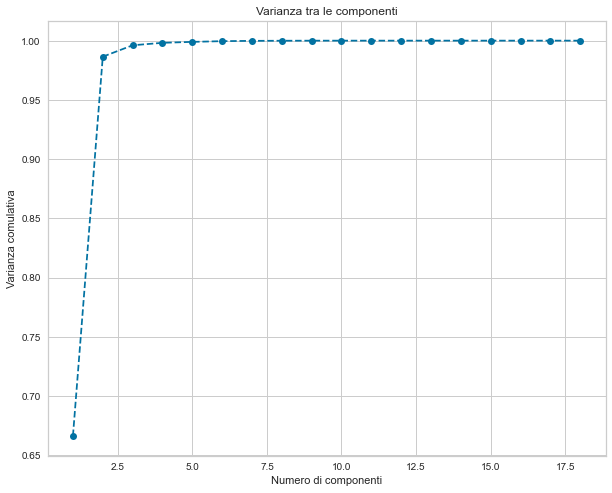

In [9]:
df_X_s_norm = KMeans.normalize_df(df_X_s.drop(columns=["unit"]))
KMeans.plot_variance_ratio(df_X_s_norm)

it 1
it 2
it 3
it 4
it 5
it 6
it 7
it 8
it 9
Numero di cluster (k-means): 3


KMeans(n_clusters=3, random_state=42)

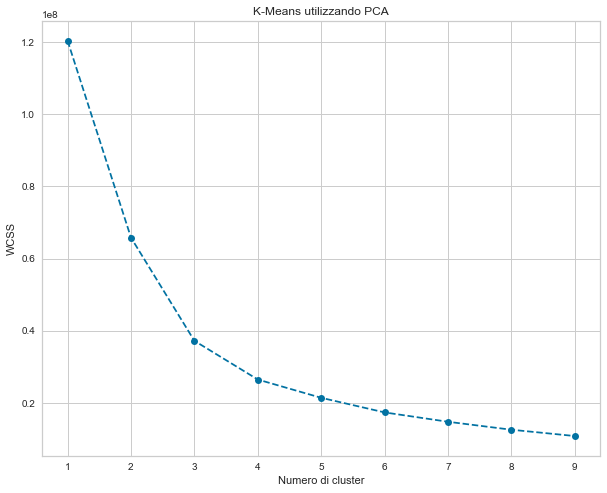

In [10]:
#prendiamo l'80% della varianza comulativa
scores_pca = KMeans.apply_pca(df_X_s_norm,2)
wcss = []
for i in range(1,10):
     kmeans_pca = KMeans.KMeans(n_clusters=i,init='k-means++',random_state=42)
     kmeans_pca.fit(scores_pca)
     wcss.append(kmeans_pca.inertia_)
     print("it",str(i))
plt.figure(figsize=(10,8))
plt.plot(range(1,10),wcss,marker='o',linestyle='--')
plt.title('K-Means utilizzando PCA')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
kl = KneeLocator(range(1,10),wcss,curve="convex",direction="decreasing")
print("Numero di cluster (k-means):",kl.elbow)
kmeans_pca = KMeans.KMeans(n_clusters=kl.elbow,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)

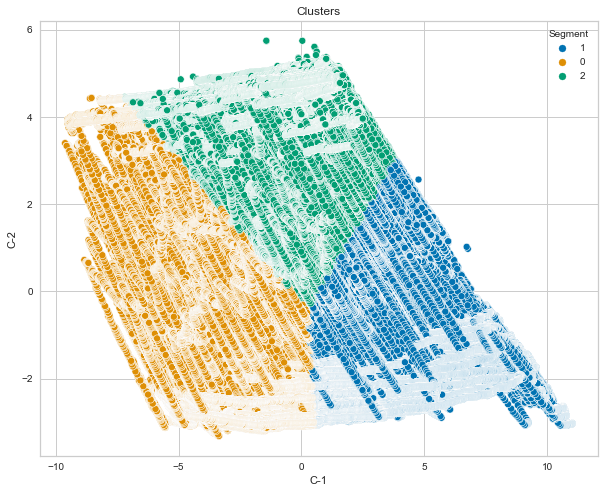

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,Wf,unit,alt,Mach,TRA,T2,C-1,C-2,Segm K-means PCA,Segment
0,628.041091,1511.541861,1927.043281,1306.041150,20.030745,14.445617,20.335782,25.648097,433.567253,440.308518,...,5.280846,1.0,3002.0,0.370377,81.122467,521.900827,10.025046,-2.238206,1,1
1,628.029107,1511.487263,1927.057002,1306.054316,20.028087,14.444604,20.333083,25.644403,433.481447,440.220073,...,5.280108,1.0,3010.0,0.370818,81.122467,521.904702,10.021315,-2.238916,1,1
2,628.036334,1511.476515,1927.009256,1305.986628,20.027190,14.444141,20.332173,25.643612,433.441995,440.180543,...,5.279434,1.0,3017.0,0.371259,81.122467,521.912580,10.018990,-2.239858,1,1
3,628.048399,1511.469365,1926.968895,1305.904807,20.025674,14.443352,20.330633,25.642218,433.385864,440.124037,...,5.278578,1.0,3030.0,0.372078,81.122467,521.926210,10.015401,-2.241973,1,1
4,628.051452,1511.428821,1926.871474,1305.799090,20.023900,14.442366,20.328833,25.640444,433.309866,440.047709,...,5.277352,1.0,3038.0,0.372519,81.122467,521.930527,10.011560,-2.242486,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6779651,565.800179,1277.058259,1502.594320,1142.177061,15.950583,13.629508,16.193486,18.220479,224.784836,229.525858,...,2.159488,10.0,3031.0,0.234738,26.718559,513.457396,1.552931,4.777321,2,2
6779652,565.818559,1277.108574,1502.656699,1142.234454,15.953717,13.631977,16.196667,18.224022,224.836274,229.578329,...,2.160036,10.0,3024.0,0.234486,26.718559,513.471020,1.556743,4.778026,2,2
6779653,565.839028,1277.158136,1502.728572,1142.299834,15.957096,13.634728,16.200097,18.227830,224.887760,229.630802,...,2.160619,10.0,3017.0,0.234297,26.718559,513.487702,1.560659,4.778647,2,2
6779654,565.863014,1277.210866,1502.801785,1142.361098,15.960785,13.637842,16.203843,18.232013,224.941032,229.685135,...,2.161217,10.0,3010.0,0.234234,26.718559,513.509052,1.564605,4.779054,2,2


In [11]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)
KMeans.view_kmeans_results_2d(df_segm_pca_kmeans,scores_pca,kmeans_pca)

In [12]:
KMeans.calculate_centroids(df_segm_pca_kmeans,scores_pca,"",0)

-9.008823700773655e-16 0.9999999999999998
(2638777, 19)
6.638970757195197e-17 0.9999999999999959
(2232811, 19)
-2.425383294239959e-15 1.0000000000000002
(1908068, 19)


,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,group
mean,553.767253,1314.704205,1633.630027,1091.387895,9.983377,7.546436,10.135408,12.596420,194.645040,197.970265,7.247304,2024.683860,8188.606069,2.093039,5.042495,24229.839852,0.651896,70.521827,469.077949,0.0
mean,593.815749,1407.638065,1755.325011,1199.801771,15.583526,11.783545,15.820838,19.494550,306.059904,311.251566,12.335176,2073.214516,8489.234676,3.455330,5.417534,10226.476395,0.477313,67.692709,504.602301,1.0
mean,563.459337,1275.547728,1508.590863,1100.464208,14.232920,11.927133,14.449665,16.681587,217.004981,221.485949,11.696814,1717.045017,8047.315479,2.109327,5.393829,9216.522199,0.433492,36.650852,504.619986,2.0


Text(0, 0.5, 'Flight Class # [-]')

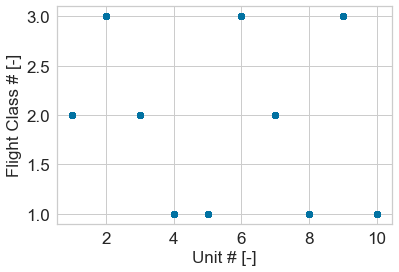

In [13]:
labelsize = 17
plt.plot(df_A.unit, df_A.Fc, 'o')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit # [-]', fontsize=labelsize)
plt.ylabel('Flight Class # [-]', fontsize=labelsize )

In [14]:
dic = {}
for i in range(1,11):
    dic[i] = int(df_A[df_A.unit==i]["Fc"].iloc[0])
dic

{1: 2, 2: 3, 3: 2, 4: 1, 5: 1, 6: 3, 7: 2, 8: 1, 9: 3, 10: 1}

In [15]:
df_segm_pca_kmeans['class'] = df_segm_pca_kmeans['unit'].map(dic)
df_segm_pca_kmeans

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,unit,alt,Mach,TRA,T2,C-1,C-2,Segm K-means PCA,Segment,class
0,628.041091,1511.541861,1927.043281,1306.041150,20.030745,14.445617,20.335782,25.648097,433.567253,440.308518,...,1.0,3002.0,0.370377,81.122467,521.900827,10.025046,-2.238206,1,1,2
1,628.029107,1511.487263,1927.057002,1306.054316,20.028087,14.444604,20.333083,25.644403,433.481447,440.220073,...,1.0,3010.0,0.370818,81.122467,521.904702,10.021315,-2.238916,1,1,2
2,628.036334,1511.476515,1927.009256,1305.986628,20.027190,14.444141,20.332173,25.643612,433.441995,440.180543,...,1.0,3017.0,0.371259,81.122467,521.912580,10.018990,-2.239858,1,1,2
3,628.048399,1511.469365,1926.968895,1305.904807,20.025674,14.443352,20.330633,25.642218,433.385864,440.124037,...,1.0,3030.0,0.372078,81.122467,521.926210,10.015401,-2.241973,1,1,2
4,628.051452,1511.428821,1926.871474,1305.799090,20.023900,14.442366,20.328833,25.640444,433.309866,440.047709,...,1.0,3038.0,0.372519,81.122467,521.930527,10.011560,-2.242486,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6779651,565.800179,1277.058259,1502.594320,1142.177061,15.950583,13.629508,16.193486,18.220479,224.784836,229.525858,...,10.0,3031.0,0.234738,26.718559,513.457396,1.552931,4.777321,2,2,1
6779652,565.818559,1277.108574,1502.656699,1142.234454,15.953717,13.631977,16.196667,18.224022,224.836274,229.578329,...,10.0,3024.0,0.234486,26.718559,513.471020,1.556743,4.778026,2,2,1
6779653,565.839028,1277.158136,1502.728572,1142.299834,15.957096,13.634728,16.200097,18.227830,224.887760,229.630802,...,10.0,3017.0,0.234297,26.718559,513.487702,1.560659,4.778647,2,2,1
6779654,565.863014,1277.210866,1502.801785,1142.361098,15.960785,13.637842,16.203843,18.232013,224.941032,229.685135,...,10.0,3010.0,0.234234,26.718559,513.509052,1.564605,4.779054,2,2,1


In [16]:
for i in range(0,3):
    filtered = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"]==i]
    contatori = filtered['class'].value_counts()
    df_contatori = pd.DataFrame({'Classe': contatori.index, 'Conteggio': contatori.values})
    print("cluster",i)
    print(df_contatori)
    print("totale cluster",i,":",df_contatori["Conteggio"].sum())


cluster 0
   Classe  Conteggio
0       3    1890111
1       2     742142
2       1       6524
totale cluster 0 : 2638777
cluster 1
   Classe  Conteggio
0       1     869919
1       3     707246
2       2     655646
totale cluster 1 : 2232811
cluster 2
   Classe  Conteggio
0       1     715933
1       3     598843
2       2     593292
totale cluster 2 : 1908068
